In [5]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from beamformer import util
from beamformer import minimum_variance_distortionless_response as mvdr
from scipy.io import wavfile
from calculatePos3d import calculatePos3d
import pandas as pd 


In [6]:
def make_mono_audio(frequency: int, write_file: bool = False, duration: float = 1.0, sampling_rate: int = 44100):
    """
    Generate a mono sine wave audio signal.

    :param frequency: Frequency of the sine wave in Hz.
    :param write_file: If True, saves the generated audio as a WAV file.
    :param duration: Duration of the generated sine wave in seconds (default: 1.0s).
    :param sampling_rate: Sampling rate in Hz (default: 44100 Hz).
    :return: NumPy array containing the generated sine wave.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    result = np.sin(2 * np.pi * frequency * t)

    if write_file:
        write("updated_sin1k.wav", sampling_rate, result.astype(np.float32))

    return result

In [10]:
# def create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation):
#     """
#     Create a delay vector for microphone array beamforming.

#     :param speed_of_sound: Speed of sound in m/s.
#     :param angle_rad: Steering angle in radians.
#     :param num_mics: Number of microphones in the array.
#     :param mic_separation: Distance between adjacent microphones in meters.
#     :return: Delay vector for each microphone.
#     """
#     mic_positions = np.arange(num_mics) * mic_separation
#     delay_vector = -mic_positions * np.sin(angle_rad) / speed_of_sound
#     return delay_vector

# def set_steering_vector(delay_vector, signal_length, fs):
#     """
#     Generate a steering vector for phase shifting.

#     :param delay_vector: Delays for each microphone.
#     :param signal_length: Length of the mono audio signal.
#     :param fs: Sampling frequency in Hz.
#     :return: Steering vector for phase shifting.
#     """
#     freqs = np.fft.rfftfreq(signal_length, d=1/fs)
#     steering_vector = np.exp(-1j * 2 * np.pi * np.outer(freqs, delay_vector))
#     return steering_vector

# def delay_across_channels_py_freq(mono_audio, steering_angle, num_mics, mic_separation, fs, speed_of_sound=343.0):
#     """
#     Delays a mono audio signal across multiple microphones in the frequency domain.

#     :param mono_audio: Input mono audio signal (NumPy array).
#     :param steering_angle: Desired steering angle in degrees.
#     :param num_mics: Number of microphones in the array.
#     :param mic_separation: Distance between adjacent microphones in meters.
#     :param fs: Sampling frequency in Hz.
#     :param speed_of_sound: Speed of sound in m/s (default: 343 m/s).
#     :return: Delayed multi-channel audio signal (NumPy array).
#     """
#     if mono_audio.ndim == 1:
#         mono_audio = mono_audio[:, np.newaxis]  # Ensure column vector
#     if num_mics <= 0:
#         raise ValueError("Number of microphones must be greater than 0!")

#     steering_angle = -steering_angle  # Reverse angle for correct steering calculations

#     # FFT of the mono audio
#     mono_audio_f = np.fft.rfft(mono_audio, axis=0)

#     # Create an empty ydelay matrix
#     ydelay = np.tile(mono_audio_f, (1, num_mics))  # Replicate signal across microphones

#     # Convert angle to radians
#     angle_rad = np.radians(steering_angle)

#     # Compute delays and steering vector
#     delay = create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation)
#     steering_vector = set_steering_vector(delay, len(mono_audio), fs)

#     # Apply phase shifts
#     ydelay[:len(mono_audio_f)-1, :] *= steering_vector.T

#     # Inverse FFT to get the time-domain signal
#     result = np.fft.irfft(ydelay, axis=0)

#     return result

def create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation):
    """
    Create a delay vector for microphone array beamforming.

    :param speed_of_sound: Speed of sound in m/s.
    :param angle_rad: Steering angle in radians.
    :param num_mics: Number of microphones in the array.
    :param mic_separation: Distance between adjacent microphones in meters.
    :return: Delay vector for each microphone.
    """
    mic_positions = np.arange(num_mics) * mic_separation
    delay_vector = -mic_positions * np.sin(angle_rad) / speed_of_sound
    return delay_vector

def set_steering_vector(delay_vector, signal_length, fs):
    """
    Generate a steering vector for phase shifting.

    :param delay_vector: Delays for each microphone.
    :param signal_length: Length of the mono audio signal.
    :param fs: Sampling frequency in Hz.
    :return: Steering vector for phase shifting.
    """
    freqs = np.fft.rfftfreq(signal_length, d=1/fs)
    steering_vector = np.exp(-1j * 2 * np.pi * freqs[:, np.newaxis] * delay_vector)
    return steering_vector

def delay_across_channels_py_freq(mono_audio, steering_angle, num_mics, mic_separation, fs, speed_of_sound=343.0):
    """
    Delays a mono audio signal across multiple microphones in the frequency domain.

    :param mono_audio: Input mono audio signal (NumPy array).
    :param steering_angle: Desired steering angle in degrees.
    :param num_mics: Number of microphones in the array.
    :param mic_separation: Distance between adjacent microphones in meters.
    :param fs: Sampling frequency in Hz.
    :param speed_of_sound: Speed of sound in m/s (default: 343 m/s).
    :return: Delayed multi-channel audio signal (NumPy array).
    """
    if mono_audio.ndim == 1:
        mono_audio = mono_audio[:, np.newaxis]  # Ensure column vector
    if num_mics <= 0:
        raise ValueError("Number of microphones must be greater than 0!")

    steering_angle = -steering_angle  # Reverse angle for correct steering calculations

    # FFT of the mono audio
    mono_audio_f = np.fft.rfft(mono_audio, axis=0)

    # Create an empty ydelay matrix
    ydelay = np.tile(mono_audio_f, (1, num_mics))  # Replicate signal across microphones

    # Convert angle to radians
    angle_rad = np.radians(steering_angle)

    # Compute delays and steering vector
    delay = create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation)
    steering_vector = set_steering_vector(delay, len(mono_audio), fs)

    # Apply phase shifts (fixing broadcasting issue)
    ydelay *= steering_vector  # No transposition needed

    # Inverse FFT to get the time-domain signal
    result = np.fft.irfft(ydelay, axis=0)

    return result

In [8]:
mono_audio = make_mono_audio(1000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -86.03206412825651 and value is 1.538461685180664


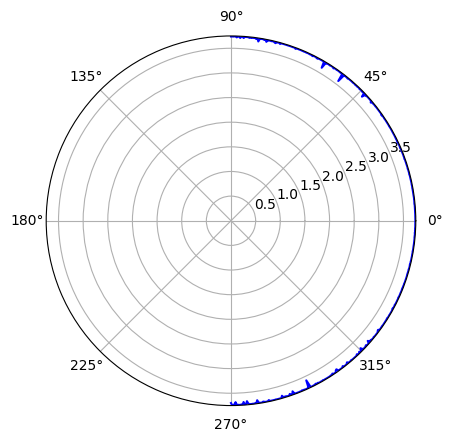

In [14]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

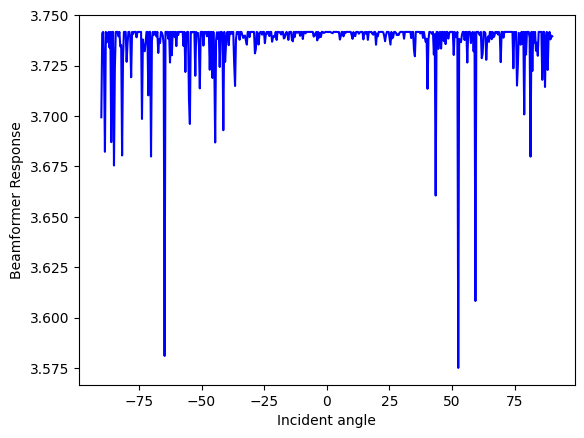

In [15]:


plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [16]:
mono_audio = make_mono_audio(5000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -88.19639278557115 and value is 1.538461685180664


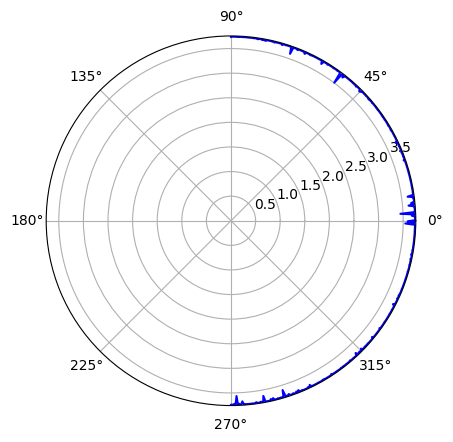

In [17]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

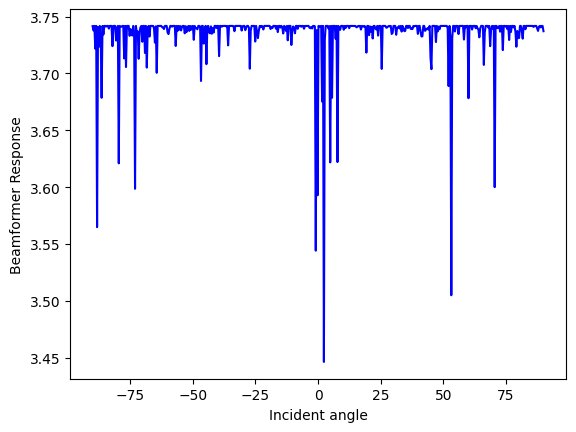

In [18]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [19]:
mono_audio = make_mono_audio(12000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -85.67134268537075 and value is 1.538461685180664


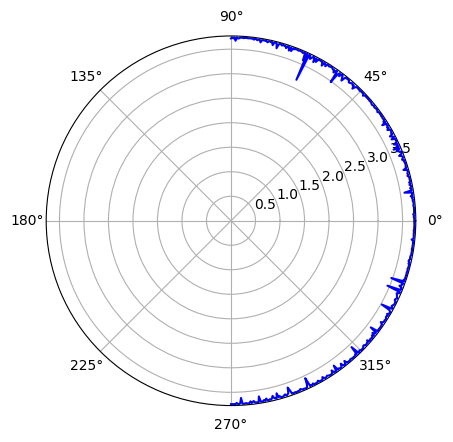

In [20]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

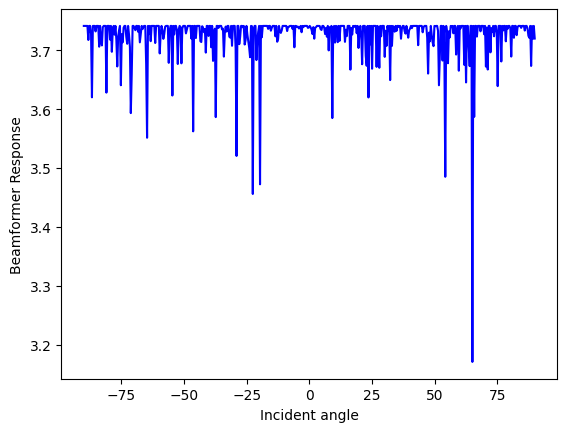

In [21]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [28]:
mono_audio = make_mono_audio(12000,False,5,85000)
SAMPLING_FREQUENCY = 85000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -84.9498997995992 and value is 1.538461685180664


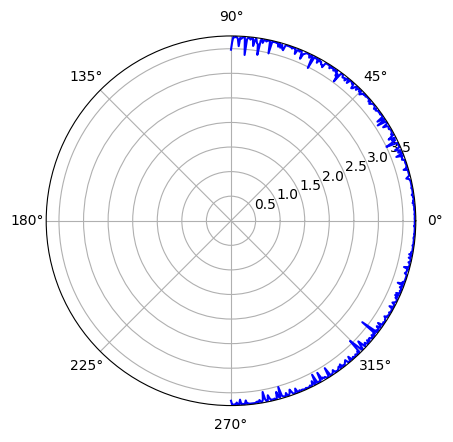

In [29]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,85000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [37]:
mono_audio = make_mono_audio(7000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -90.0 and value is 1.538461685180664


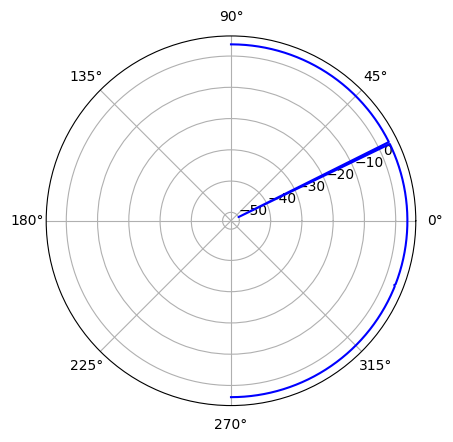

In [38]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [42]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -90.0 and value is 1.538461685180664


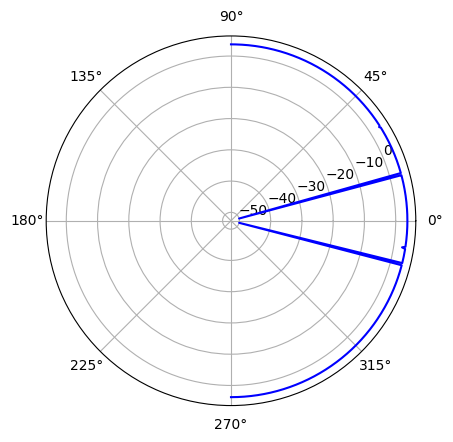

In [43]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

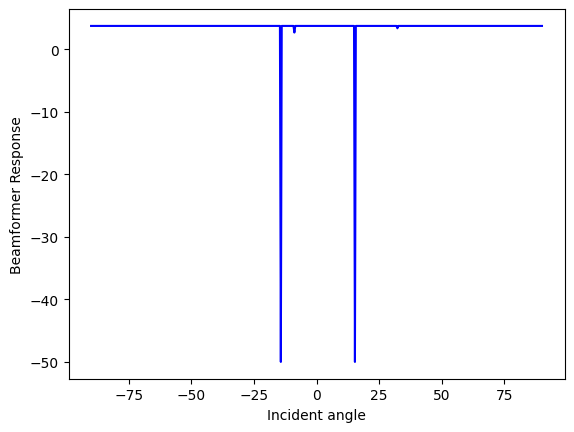

In [44]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [45]:
mono_audio = make_mono_audio(1000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -86.03206412825651 and value is 1.538461685180664


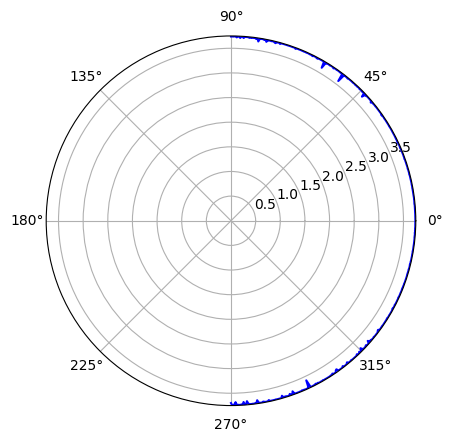

In [46]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [52]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 10
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -89.27855711422846 and value is 1.538461685180664


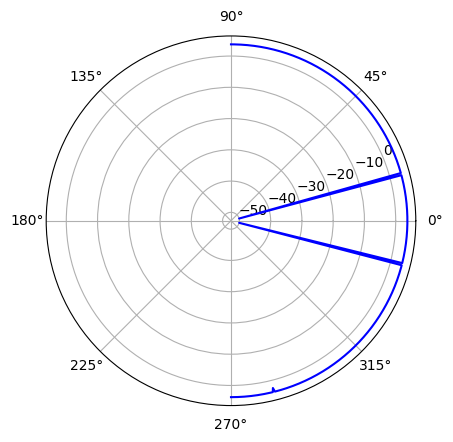

In [53]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [54]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 50
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -88.55711422845691 and value is 1.538461685180664


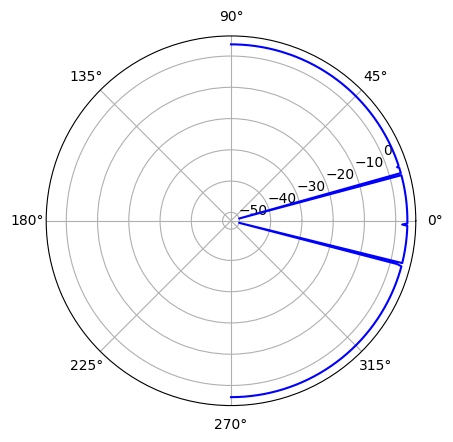

In [55]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

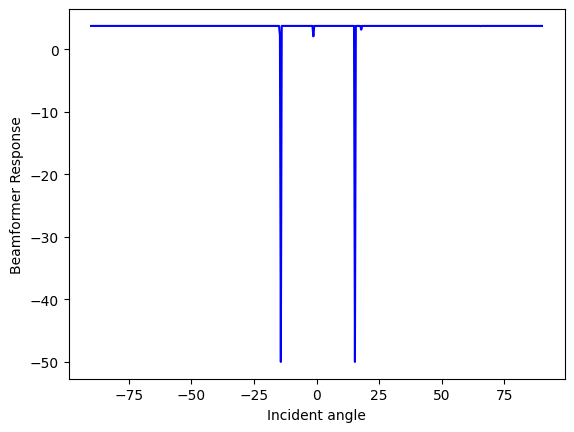

In [56]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [59]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 215
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -90.0 and value is 1.538461685180664


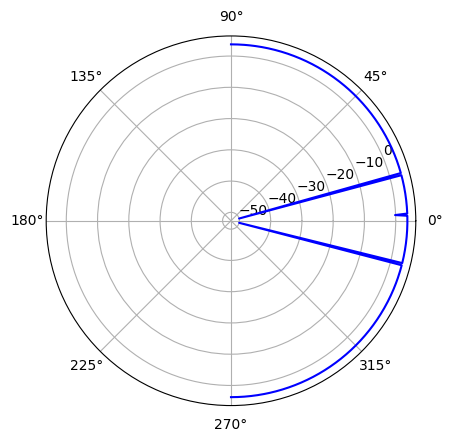

In [60]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

##old version


In [61]:
from beamformer import minimum_variance_distortionless_response2 as mvdr1


In [ ]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
LOOK_DIRECTION = 0 #deg
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -89.63927855711422 and value is 1.538461685180664


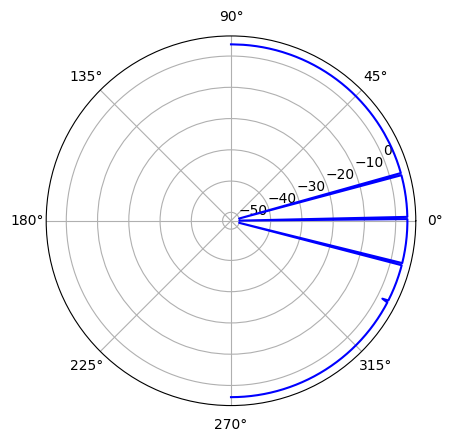

In [ ]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH) #for multi channel fft
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio) #correlation matrix

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix) #applying beamforming (convolution function)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65) #normalization




#polar plotting (Agular sweep)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [66]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 0
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


c:\Users\arind\Documents\cochlarity\mvdrbeam\beamformer\minimum_variance_distortionless_response2.py:195: RuntimeWarning: divide by zero encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
c:\Users\arind\Documents\cochlarity\mvdrbeam\beamformer\minimum_variance_distortionless_response2.py:195: RuntimeWarning: invalid value encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
c:\Users\arind\Documents\cochlarity\mvdrbeam\beamformer\minimum_variance_distortionless_response2.py:217: RuntimeWarning: invalid value encountered in matmul
  enhanced_spectrum[:, f] = np.matmul(np.conjugate(beamformer[:, f]).T, complex_spectrum[:, :, f])


max angle was at -89.63927855711422 and value is 1.538461685180664


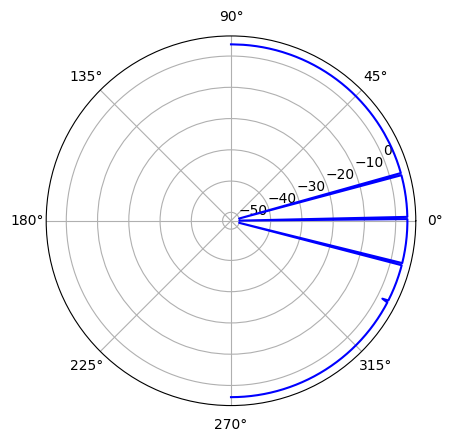

In [67]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [68]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 45
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -90.0 and value is 1.538461685180664


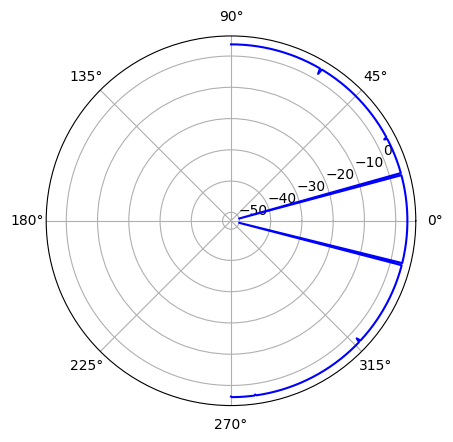

In [69]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [70]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 63
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -89.27855711422846 and value is 1.538461685180664


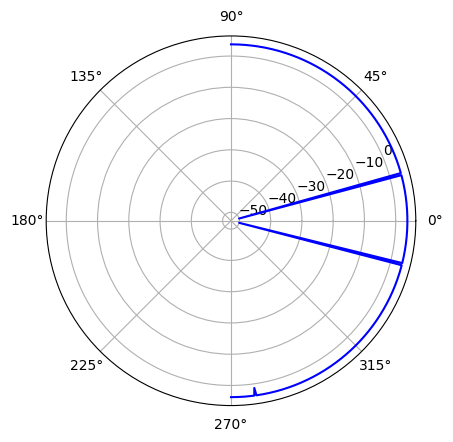

In [71]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()